# The Simulator Class

The most convenient way to use ``hera_sim`` is to use the ``Simulator`` class, which builds in all the primary functionality of the ``hera_sim`` package in an easy-to-use interface, and adds the ability to consistently write all produced effects into a ``pyuvdata.UVData`` object (and to file).


This notebook provides a brief tutorial on basic use of the ``Simulator`` class, followed by a longer, more in-depth tutorial that shows some advanced features of the class.

## Setup ##

In [51]:
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from astropy import units

import hera_sim
from hera_sim import Simulator, DATA_PATH
from uvtools.plot import labeled_waterfall
%matplotlib inline

We'll inspect the visibilities as we go along by plotting the amplitudes and phases on different axes in the same figure. Here's the function we'll be using:

In [43]:
def waterfall(sim, antpairpol=(0,1,"xx"), figsize=(6,3.5), dpi=200, title=None):
    """Convenient plotting function to show amp/phase."""
    fig, (ax1, ax2) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=figsize,
        dpi=dpi,
    )
    fig, ax1 = labeled_waterfall(
        sim.data,
        antpairpol=antpairpol,
        mode="log",
        ax=ax1,
        set_title=title,
    )
    ax1.set_xlabel(None)
    ax1.set_xticklabels(['' for tick in ax1.get_xticks()])
    fig, ax2 = labeled_waterfall(
        sim.data,
        antpairpol=antpairpol,
        mode="phs",
        ax=ax2,
        set_title=False,
    )
    return fig

## Basic Use ##

To get us started, let's make a ``Simulator`` object with 100 frequency channels spanning from 100 to 200 MHz, a half-hour of observing time using an integration time of 10.7 seconds, and a 7-element hexagonal array.

In [2]:
# Define the array layout.
array_layout = hera_sim.antpos.hex_array(
    2, split_core=False, outriggers=0
)

# Define the timing parameters.
start_time = 2458115.9  # JD
integration_time = 10.7  # seconds
Ntimes = int(30 * units.min.to("s") / integration_time)

# Define the frequency parameters.
Nfreqs = 100
bandwidth = 1e8  # Hz
start_freq = 1e8  # Hz

# Create an instance of the Simulator class.
sim = Simulator(
    Nfreqs=Nfreqs,
    start_freq=start_freq,
    bandwidth=bandwidth,
    Ntimes=Ntimes,
    start_time=start_time, 
    integration_time=integration_time, 
    array_layout=array_layout,
)

### Overview ###

The ``Simulator`` class adds some attributes for conveniently accessing metadata:

In [3]:
# Observed frequencies in GHz
sim.freqs[::10]

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])

In [4]:
# Observed Local Sidereal Times (LSTs) in radians
sim.lsts[::10]

array([4.58108965, 4.58889222, 4.59669478, 4.60449734, 4.61229991,
       4.62010247, 4.62790503, 4.6357076 , 4.64351016, 4.65131273,
       4.65911529, 4.66691785, 4.67472042, 4.68252298, 4.69032555,
       4.69812811, 4.70593067])

In [5]:
# Array layout in local East-North-Up (ENU) coordinates
sim.antpos

{0: array([-7.30000000e+00,  1.26439709e+01, -4.36185665e-09]),
 1: array([ 7.30000000e+00,  1.26439709e+01, -3.99203159e-09]),
 2: array([-1.46000000e+01,  6.98581573e-09, -4.65185394e-09]),
 3: array([ 0.00000000e+00,  7.20559015e-09, -4.28202888e-09]),
 4: array([ 1.46000000e+01,  7.42536457e-09, -3.91220382e-09]),
 5: array([-7.30000000e+00, -1.26439709e+01, -4.57202631e-09]),
 6: array([ 7.30000000e+00, -1.26439709e+01, -4.20220125e-09])}

In [42]:
# Polarization array
sim.pols

['xx']

You can also generate a plot of the array layout using the ``plot_array`` method:

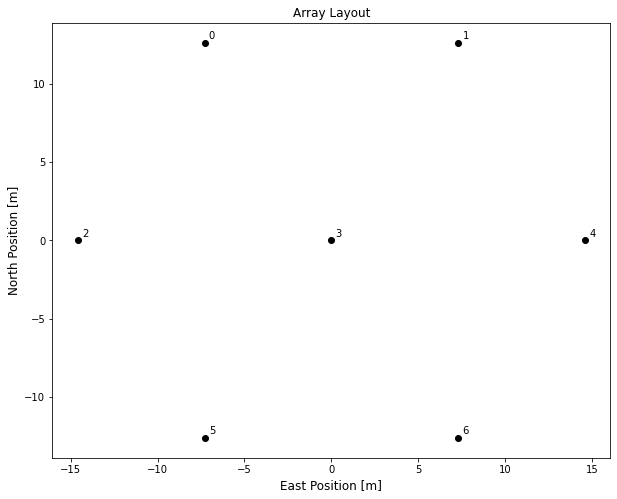

In [6]:
fig = sim.plot_array()

The ``data`` attribute can be used to access the ``UVData`` object used to store the simulated data and metadata:

In [7]:
type(sim.data)

pyuvdata.uvdata.uvdata.UVData

### Adding Effects ###

Effects may be added to a simulation by using the ``add`` method. This method takes one argument and variable keyword arguments: the required argument ``component`` may be either a string identifying the name of a ``hera_sim`` class (or an alias thereof, see below), or a callable object that has either ``lsts`` or  ``freqs`` (or both) as a parameter(s) and returns an object with shape (``lsts.size``, ``freqs.size``) or (``freqs.size``,) (granted, the ``Simulator`` does not do a check on the input parameters or the shape of returned values, but passing a callable object that returns something incorrectly shaped will likely result in an exception being raised). Let's walk through an example.

We'll start by simulating diffuse foreground emission. For simplicity, we'll be using the H1C season default settings so that the number of extra parameters we need to specify is minimal.

In [9]:
# Use H1C season defaults.
hera_sim.defaults.set("h1c")

In [46]:
# Start off by simulating some foreground emission.
sim.add("diffuse_foreground")

You have not specified how to seed the random state.This effect might not be exactly recoverable.


FixedFormatter should only be used together with FixedLocator


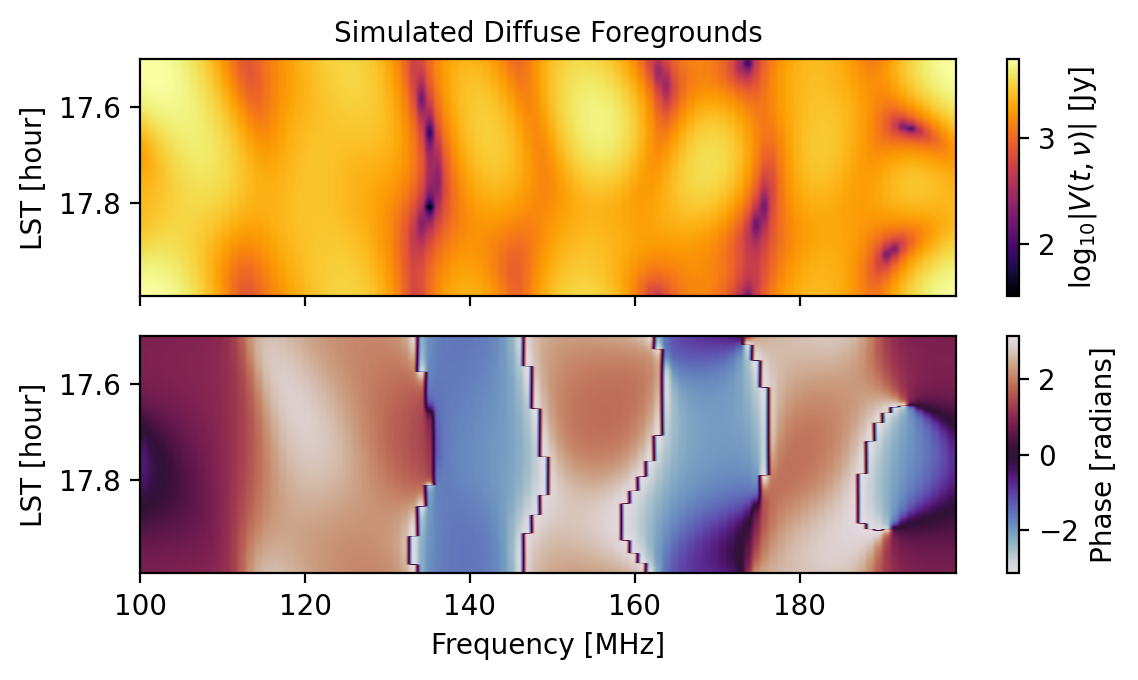

In [47]:
# Let's check out the data for the (0,1) baseline.
fig = waterfall(sim, title="Simulated Diffuse Foregrounds")
fig.tight_layout()

That was simple enough; however, basic use like this does not ensure that the simulation is as realistic as it can be with the tools provided by ``hera_sim``. For example, data that should be redundant is not redundant by default:

In [12]:
# (0,1) and (5,6) are redundant baselines, but...
np.all(sim.get_data(0,1,"xx") == sim.get_data(5,6,"xx"))

False

We can ensure that a simulated effect that should be redundant is redundant by specifying that we use a "redundant" seed:

In [33]:
sim.refresh()  # Clear the contents and zero the data
sim.add("diffuse_foreground", seed="redundant")

In [34]:
np.all(sim.get_data(0,1,"xx") == sim.get_data(5,6,"xx"))

True

In [35]:
# Go one step further with this example.
all_redundant = True
for red_grp in sim.red_grps:
    if len(red_grp) == 1:
        continue  # Nothing to see here
    base_vis = sim.get_data(red_grp[0])
    # Really check that data is redundant.
    for baseline in red_grp[1::]:
        all_redundant &= np.allclose(base_vis, sim.get_data(baseline))
all_redundant

True

### Retrieving Simulated Effects ###

The parameter values used for simulating an effect are stored so that the effect may be recovered at a later time by re-simulating the effect. For effects that have a random element (like bandpass gains or thermal noise), you'll want to make sure that the ``seed`` parameter is specified to ensure that the random state can be configured appropriately.

In [36]:
sim.refresh()
vis = sim.add("noiselike_eor", eor_amp=1e-3, seed="redundant", ret_vis=True)
sim.add("gains", seed="once")

In [37]:
# The data has been modified by the gains, so it won't match the original.
np.allclose(vis, sim.data.data_array)

False

In [38]:
# We can recover the simulated effect if we wanted to, though.
np.allclose(vis, sim.get("noiselike_eor"))

True

In [39]:
# Just to really drive the point home.
gains = sim.get("gains")
new_vis = vis.copy()
for ant1, ant2, pol, blt_inds, pol_ind in sim._iterate_antpair_pols():
    total_gain = gains[(ant1, pol[0])] * np.conj(gains[(ant2, pol[1])])
    new_vis[blt_inds,0,:,pol_ind] *= total_gain
np.allclose(new_vis, sim.data.data_array)

True

Each time a component is added to the simulation, it is logged in the history:

In [40]:
print(sim.data.history)

hera_sim v0.0.0: Added noiselikeeor using parameters:
eor_amp = 0.001
fringe_filter_type = tophat
hera_sim v0.0.0: Added bandpass using parameters:
bp_poly = <hera_sim.interpolators.Bandpass object at 0x7f2d63692910>



### Saving A Simulation ###

Finally, we'll often want to write simulation data to disk. The simplest way to do this is with the ``write`` method:

In [54]:
tempdir = Path(tempfile.mkdtemp())
filename = tempdir / "simple_example.uvh5"
sim.write(filename, save_format="uvh5")

In [59]:
filename in tempdir.iterdir()

True

In [63]:
# Check that the data is the same.
sim2 = Simulator(data=filename)
is_equiv = True
# Just do a basic check.
for attr in ("data_array", "freq_array", "time_array", "antenna_positions"):
    is_equiv &= np.all(getattr(sim.data, attr) == getattr(sim2.data, attr))
is_equiv

Telescope hera_sim is not in known_telescopes.


True

This concludes the section on basic use of the ``Simulator``. If you would like to know which effects can be simulated, then you can view all of the known models via:

In [41]:
print(hera_sim.components.list_all_components())

array:
  lineararray
  hexarray
foreground:
  diffuseforeground | diffuse_foreground
  pointsourceforeground | pntsrc_foreground
noise:
  thermalnoise | thermal_noise
rfi:
  stations | rfi_stations
  impulse | rfi_impulse
  scatter | rfi_scatter
  dtv | rfi_dtv
gain:
  bandpass | gains | bandpass_gain
  reflections | reflection_gains | sigchain_reflections
crosstalk:
  crosscouplingcrosstalk | cross_coupling_xtalk
  crosscouplingspectrum | cross_coupling_spectrum | xtalk_spectrum
  whitenoisecrosstalk | whitenoise_xtalk | white_noise_xtalk
eor:
  noiselikeeor | noiselike_eor



## Advanced Use ##

The preceding examples should provide enough information to get you started with the ``Simulator``. The rest of this notebook shows some of the more advanced features offered by the ``Simulator``.

### Singling Out Baselines/Antennas/Polarizations ###

### Pre-Computing Fringe-Rate/Delay Filters ###

### Using Custom Models ###

#### Registering Classes ####

### Saving Data in Chunks ###

## The ``run_sim`` Method ##

The ``Simulator`` class also features the ``run_sim`` method, which allows you to run an entire simulation with a single method call.

### Defining A Configuration Dictionary ###

### Using A Configuration File ###